In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 1. 정확한 경로에서 폰트 불러오기
font_path = "C:/Windows/Fonts/malgun.ttf"  # '맑은 고딕' 경로
font_prop = fm.FontProperties(fname=font_path)

# 2. 전체 설정 적용 (폰트 이름 직접 명시)
plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["axes.unicode_minus"] = False
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)



In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 1. 정확한 폰트 경로
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()  # ✅ 핵심
plt.rcParams["axes.unicode_minus"] = False


In [65]:
import pandas as pd
# 1. 데이터 불러오기
df = pd.read_csv("고정스냅샷(10월17일).csv", low_memory=False)

In [13]:
df.

NameError: name 'df2' is not defined

In [58]:
df[["character_exp", "event"]].corr()

,character_exp,event
character_exp,1.000000,-0.105475
event,-0.105475,1.000000


In [66]:
df = df[df["character_class_level"] >= 6].copy()

In [67]:
# 제로 유저 여부 구분
df["is_zero"] = (df["character_class"] == "제로").astype(int)

# 제로 유저 평균 인기도
zero_popularity_mean = df.loc[df["is_zero"] == 1, "popularity"].mean()

# 비제로 유저 평균 인기도
nonzero_popularity_mean = df.loc[df["is_zero"] == 0, "popularity"].mean()

print(f"제로 유저 평균 인기도: {zero_popularity_mean:.2f}")
print(f"비제로 유저 평균 인기도: {nonzero_popularity_mean:.2f}")


제로 유저 평균 인기도: 2430.50
비제로 유저 평균 인기도: 376.45


In [71]:
# 1. popularity → 숫자 변환
df["popularity_clean"] = pd.to_numeric(df["popularity"], errors="coerce")

# 2. 제로 유저 제외
df["is_zero"] = (df["character_class"] == "제로").astype(int)

# 3. 제로 유저 NaN 처리
df.loc[df["is_zero"] == 1, "popularity_clean"] = np.nan

# 4. Z-score 정규화 (음수 포함)
def safe_zscore(x):
    if x.std() == 0 or np.isnan(x.std()):
        return np.nan
    return (x - x.mean()) / x.std()

df["popularity_zscore"] = df.groupby("character_class")["popularity_clean"].transform(safe_zscore)


In [72]:
# 1. 구간 경계 정의
bins = [270, 275, 280, 285, 290, 300]  # 마지막은 290+용 상한선
labels = ["270-274", "275-279", "280-284", "285-289", "290+"]

# 2. 구간 나누기 (right=False → 왼쪽 포함, 오른쪽 미포함)
df["level_segment"] = pd.cut(df["character_level"], bins=bins, labels=labels, right=False)

# 3. 구간별 인원 수 확인
print(df["level_segment"].value_counts().sort_index())


level_segment
270-274    55324
275-279    57776
280-284    56979
285-289    33111
290+        5622
Name: count, dtype: int64


In [74]:
# 1. 원핫 인코딩 (drop_first=True → 첫 구간은 기준으로 제외됨)
level_dummies = pd.get_dummies(df["level_segment"], prefix="level", drop_first=True)

In [75]:
df["liberation_flag"] = df["liberation_quest_clear_flag"].astype(int)

In [76]:
# 1. 무릉 도장 도전 여부 (기록 1층 이상이면 도전한 것)
df["dojang_active_flag"] = (df["dojang_best_floor"] > 0).astype(int)

# 2. 진성유저 기준 무릉 40층 이상 여부
df["dojang_40plus_flag"] = (df["dojang_best_floor"] >= 40).astype(int)

# 3. 기록이 0인 사람은 모델 학습에서 층수 자체를 NaN 처리 (활동 유무와 분리)
df.loc[df["dojang_active_flag"] == 0, "dojang_best_floor"] = np.nan


In [79]:
def assign_segment(row):
    level = row['character_level']
    authentic_sum = row['authentic_sum']

    if 270 <= level < 275:
        threshold = 18
    elif 275 <= level < 280:
        threshold = 28
    elif 280 <= level < 285:
        threshold = 38
    elif 285 <= level < 290:
        threshold = 48
    elif level >= 290:
        threshold = 68
    else:
        return '대상 외'

    if authentic_sum >= threshold:
        return '일반 유저'
    else:
        return '레벨 대비 저성장'

df['segment'] = df.apply(assign_segment, axis=1)


In [80]:
segment_dummies = pd.get_dummies(df["segment"], prefix="segment", drop_first=True)

In [81]:
# arcane_sum 수치형으로 정제
df["arcane_sum"] = pd.to_numeric(df["arcane_sum"], errors="coerce")

# 아케인 심볼 만렙 여부 컬럼 생성
df["arcane_max_flag"] = (df["arcane_sum"] == 120).astype(int)

# 비율 계산
arcane_counts = df["arcane_max_flag"].value_counts(normalize=True) * 100
arcane_counts = arcane_counts.rename(index={0: "미만", 1: "만렙"}).rename("비율(%)").to_frame()

In [82]:
arcane_counts 

,비율(%)
arcane_max_flag,
만렙,86.838879
미만,13.161121


In [83]:
# 숫자형으로 변환 (문자/결측값 처리)
df["arcane_sum"] = pd.to_numeric(df["arcane_sum"], errors="coerce")

# 만렙 여부 이진 피처 생성
df["arcane_max_flag"] = (df["arcane_sum"] == 120).astype(int)


In [109]:
# 세트 장비 수치형 변환
for col in ["set_lubatiss_count", "set_absorlab_count", "set_arcane_count", "set_eternal_count"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 해방 여부 이진 처리
df["liberation_flag"] = df["liberation_quest_clear_flag"].astype(int)

# 세트 총합 계산
df["set_total_count"] = (
    df["set_lubatiss_count"]
    + df["set_absorlab_count"]
    + df["set_arcane_count"]
    + df["set_eternal_count"]
)

# 해방 유저만 필터링
liberated_df = df[df["liberation_flag"] == 0]
set_count_distribution = liberated_df["set_total_count"].value_counts().sort_index()
set_count_distribution

set_total_count
0       3252
1       3480
2        712
3        661
4       1260
5       1374
6        984
7       3875
8     115371
9       2133
10       634
Name: count, dtype: int64

In [117]:
# 세트 장비 수치형 변환
for col in ["set_lubatiss_count", "set_absorlab_count", "set_arcane_count", "set_eternal_count"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 해방 여부 이진 처리
df["liberation_flag"] = df["liberation_quest_clear_flag"].astype(int)

# 세트 총합 계산
df["set_total_count"] = (
    df["set_lubatiss_count"]
    + df["set_absorlab_count"]
    + df["set_arcane_count"]
    + df["set_eternal_count"]
)

# 해방 유저만 필터링
liberated_df = df[df["liberation_flag"] == 1]
set_count_distribution = liberated_df["set_total_count"].value_counts().sort_index()
set_count_distribution

set_total_count
0        14
1       287
2        81
3        69
4        50
5       231
6       140
7       366
8      1874
9     16652
10    55312
Name: count, dtype: int64

In [114]:
# 조건 기반 세트 조합 분류 함수 정의
def classify_set_combo(row):
    luba = row["set_lubatiss_count"]
    abs = row["set_absorlab_count"]
    arc = row["set_arcane_count"]
    eter = row["set_eternal_count"]

    # 에테 풀셋
    if eter >= 7:
        return "에테르넬 풀셋"
    
    # 에테 + 아케인 (예: 3에테 + 4아케인 이상)
    if eter >= 3 and arc >= 4:
        return "에테르넬 + 아케인셰이드"
    
    # 에테 + 앱솔 (예: 2에테 + 4앱 이상)
    if eter >= 2 and abs >= 4:
        return "에테르넬 + 앱솔랩스"
    
    # 루타 + 아케인 (예: 3루타 + 4아케인 이상)
    if luba >= 3 and arc >= 4:
        return "루타비스 + 아케인셰이드"
    
    # 루타 + 앱솔 (예: 2루타 + 4앱 이상)
    if luba >= 2 and abs >= 4:
        return "루타비스 + 앱솔랩스"
    
    # 그 외
    return "세트효과 부족/혼합"

# 적용
df["set_combo_group"] = df.apply(classify_set_combo, axis=1)

# 결과 요약
set_combo_summary = df["set_combo_group"].value_counts().to_frame(name="유저 수")
print(set_combo_summary)

                  유저 수
set_combo_group       
루타비스 + 앱솔랩스      96358
루타비스 + 아케인셰이드    69138
세트효과 부족/혼합       24415
에테르넬 + 아케인셰이드    11857
에테르넬 + 앱솔랩스       6845
에테르넬 풀셋            199


In [115]:
set_combo_dummies = pd.get_dummies(df["set_combo_group"], prefix="set_combo", drop_first=True)

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 208812 entries, 0 to 209315
Data columns (total 66 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   ocid                         208812 non-null  object        
 1   exp_1010                     208812 non-null  object        
 2   ranking                      208812 non-null  object        
 3   character_name               208812 non-null  object        
 4   world_name                   208812 non-null  object        
 5   character_gender             208812 non-null  object        
 6   character_class              208812 non-null  object        
 7   character_class_level        208812 non-null  int64         
 8   character_level              208812 non-null  int64         
 9   character_exp                208812 non-null  float64       
 10  character_exp_rate           208812 non-null  object        
 11  character_guild_name         20

In [123]:
# 1. 날짜 문자열 → datetime 변환
df["character_date_create"] = pd.to_datetime(df["character_date_create"], errors="coerce")

# 2. 타임존 제거 (tz-aware → tz-naive)
df["character_date_create"] = df["character_date_create"].dt.tz_localize(None)

# 3. 기준일도 tz-naive로 유지
reference_date = pd.to_datetime("2024-10-17")

# 4. 경과일수 계산
df["character_age_days"] = (reference_date - df["character_date_create"]).dt.days


In [126]:
df["new_user_flag"] = (df["character_age_days"] < 90).astype(int)
df["veteran_flag"] = (df["character_age_days"] >= 2000).astype(int)


In [128]:
# 신규 유저 플래그 (90일 미만)
df["new_user_flag"] = (df["character_age_days"] < 90).astype(int)

# 고인물 플래그 (2000일 이상)
df["veteran_flag"] = (df["character_age_days"] >= 2000).astype(int)

# 비율 계산
flag_distribution = pd.DataFrame({
    "유저 수": {
        "신규 유저 (<90일)": df["new_user_flag"].sum(),
        "고인물 (>=2000일)": df["veteran_flag"].sum()
    }
})

flag_distribution["비율 (%)"] = (flag_distribution["유저 수"] / len(df)) * 100
flag_distribution

,유저 수,비율 (%)
신규 유저 (<90일),2824,1.352413
고인물 (>=2000일),64323,30.804264


In [124]:
print(df["character_age_days"].describe())
print(df[df["character_age_days"] < 0][["character_name", "character_date_create", "character_age_days"]])


count    208812.000000
mean       1607.513926
std        1305.261658
min          11.000000
25%         488.000000
50%        1400.000000
75%        2292.000000
max        7841.000000
Name: character_age_days, dtype: float64
Empty DataFrame
Columns: [character_name, character_date_create, character_age_days]
Index: []


In [ ]:
# 2. 기존 피처 X와 병합
X = pd.concat([X, level_dummies], axis=1)

In [135]:
df.to_csv("머신러닝용고정스냅샷.csv", index = False)

In [136]:
df = pd.read_csv("머신러닝용고정스냅샷.csv", low_memory=False)

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208812 entries, 0 to 208811
Data columns (total 61 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ocid                         208812 non-null  object 
 1   exp_1010                     208812 non-null  object 
 2   ranking                      208812 non-null  object 
 3   character_name               208812 non-null  object 
 4   world_name                   208812 non-null  object 
 5   character_gender             208812 non-null  object 
 6   character_class              208812 non-null  object 
 7   character_class_level        208812 non-null  int64  
 8   character_level              208812 non-null  int64  
 9   character_exp                208812 non-null  float64
 10  character_exp_rate           208812 non-null  object 
 11  character_guild_name         208812 non-null  object 
 12  character_date_create        208812 non-null  object 
 13 

In [134]:
# 제거할 컬럼 목록 정의
columns_to_drop = [
    "popularity_clean", "popularity_log", "popularity_log_zscore",
    "set_total", "set_total_count"
]

# 존재하는 컬럼만 안전하게 제거
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# 결과 컬럼 개수 및 이름 확인
df.columns.tolist()

['ocid',
 'exp_1010',
 'ranking',
 'character_name',
 'world_name',
 'character_gender',
 'character_class',
 'character_class_level',
 'character_level',
 'character_exp',
 'character_exp_rate',
 'character_guild_name',
 'character_date_create',
 'access_flag',
 'liberation_quest_clear_flag',
 'popularity',
 'arcane_sum',
 'authentic_sum',
 'set_absorlab_count',
 'set_lubatiss_count',
 'set_arcane_count',
 'set_eternal_count',
 'dojang_best_floor',
 'union_level',
 'union_artifact_level',
 'union_artifact_exp',
 'union_artifact_point',
 'exp_1017',
 'access_1017',
 'exp_1024',
 'access_1024',
 'exp_1031',
 'access_1031',
 'exp_1107',
 'access_1107',
 'exp_1114',
 'access_1114',
 'exp_1121',
 'access_1121',
 'exp_1128',
 'access_1128',
 'exp_1205',
 'access_1205',
 'exp_1212',
 'access_1212',
 'exp_1219',
 'access_1219',
 'event',
 'duration',
 'is_zero',
 'popularity_zscore',
 'level_segment',
 'liberation_flag',
 'dojang_active_flag',
 'dojang_40plus_flag',
 'segment',
 'arcane_max_f

In [ ]:
import pandas as pd
import numpy as np
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
df = pd.read_csv("머신러닝용고정스냅샷.csv", low_memory=False)

# 수치형 처리
for col in ["character_level", "character_exp", "popularity", "authentic_sum",
            "set_lubatiss_count", "set_absorlab_count", "set_arcane_count", "set_eternal_count"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 날짜 처리
df["character_date_create"] = pd.to_datetime(df["character_date_create"], errors="coerce")
df["character_date_create"] = df["character_date_create"].dt.tz_localize(None)
reference_date = pd.to_datetime("2024-10-17")
df["character_age_days"] = (reference_date - df["character_date_create"]).dt.days

# 신규/고인물 플래그
df["new_user_flag"] = (df["character_age_days"] < 90).astype(int)
df["veteran_flag"] = (df["character_age_days"] >= 2000).astype(int)

# 길드 플래그
df["guild_flag"] = (df["character_guild_name"] != "미가입").astype(int)

# 해방 여부
df["liberation_flag"] = df["liberation_quest_clear_flag"].astype(int)

# 무릉 도전 플래그
df["dojang_active_flag"] = (df["dojang_best_floor"] > 0).astype(int)
df["dojang_40plus_flag"] = (df["dojang_best_floor"] >= 40).astype(int)
df.loc[df["dojang_active_flag"] == 0, "dojang_best_floor"] = pd.NA

# 아케인 만렙 플래그
df["arcane_max_flag"] = (df["arcane_sum"] == 120).astype(int)

# 어센틱 성장 세그먼트
def assign_segment(row):
    level = row['character_level']
    authentic_sum = row['authentic_sum']
    if 270 <= level < 275:
        threshold = 18
    elif 275 <= level < 280:
        threshold = 28
    elif 280 <= level < 285:
        threshold = 38
    elif 285 <= level < 290:
        threshold = 48
    elif level >= 290:
        threshold = 68
    else:
        return '대상 외'
    return '일반 유저' if authentic_sum >= threshold else '레벨 대비 저성장'
df["segment"] = df.apply(assign_segment, axis=1)

# 인기도 z-score
df["popularity_clean"] = df["popularity"].where(df["popularity"] < 1e5, pd.NA)
df["popularity_log"] = df["popularity_clean"].apply(lambda x: np.log1p(x) if pd.notnull(x) else pd.NA)
df["popularity_log_zscore"] = (
    (df["popularity_log"] - df["popularity_log"].mean()) / df["popularity_log"].std()
)

# 세트 조합 그룹
def classify_set_combo(row):
    luba = row["set_lubatiss_count"]
    abs = row["set_absorlab_count"]
    arc = row["set_arcane_count"]
    eter = row["set_eternal_count"]
    if eter >= 7:
        return "에테르넬 풀셋"
    if eter >= 3 and arc >= 4:
        return "에테르넬 + 아케인셰이드"
    if eter >= 2 and abs >= 4:
        return "에테르넬 + 앱솔랩스"
    if luba >= 3 and arc >= 4:
        return "루타비스 + 아케인셰이드"
    if luba >= 2 and abs >= 4:
        return "루타비스 + 앱솔랩스"
    return "세트효과 부족/혼합"
df["set_combo_group"] = df.apply(classify_set_combo, axis=1)

# 레벨 구간
bins = [270, 275, 280, 285, 290, 300]
labels = ["270-274", "275-279", "280-284", "285-289", "290+"]
df["level_segment"] = pd.cut(df["character_level"], bins=bins, labels=labels, right=False)

# 전직 6차 이상 필터링 후 샘플링
df = df[df["character_class_level"] >= 6].copy()
df_sample = df.sample(n=20000, random_state=42)

# 사용 피처
categorical = pd.get_dummies(df_sample[["segment", "set_combo_group", "level_segment"]], drop_first=True)
features = pd.concat([
    df_sample[[
        "character_level", "character_age_days", "new_user_flag", "veteran_flag",
        "liberation_flag", "guild_flag", "arcane_max_flag", "authentic_sum",
        "popularity_log_zscore", "dojang_active_flag", "dojang_40plus_flag"
    ]],
    categorical
], axis=1)

# 타겟
y = Surv.from_dataframe("event", "duration", df_sample)

# 학습 분할
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

# 모델 학습
rsf = RandomSurvivalForest(
    n_estimators=50,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
rsf.fit(X_train, y_train)

# 평가
cindex = concordance_index_censored(y_test["event"], y_test["duration"], rsf.predict(X_test))[0]
print(f"✅ Concordance Index (C-index): {cindex:.4f}")


In [157]:
# ✅ 라이브러리
import pandas as pd
import numpy as np
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv("머신러닝용고정스냅샷.csv", low_memory=False)
df["popularity_zscore"] = df["popularity_zscore"].fillna(0)
# 일부 샘플링 (예: 20,000건)
df_sample = df.sample(n=20000, random_state=42).copy()


# 수치형 안정화
numeric_cols = ["character_level", "authentic_sum", "popularity_zscore", "character_age_days"]
for col in numeric_cols:
    df_sample[col] = pd.to_numeric(df_sample[col], errors="coerce")

# 범주형 피처 원핫 인코딩
categorical_cols = ["segment", "level_segment", "set_combo_group","character_class", "world_name"]
df_encoded = pd.get_dummies(df_sample[categorical_cols], drop_first=True)


# 최종 피처셋
X = pd.concat([
    df_sample[[
        "character_level", "authentic_sum", "popularity_zscore", "character_age_days",
        "new_user_flag", "veteran_flag", "liberation_flag", "arcane_max_flag",
        "dojang_active_flag", "dojang_40plus_flag"
    ]],
    df_encoded
], axis=1)

# 타겟 생성
y = Surv.from_dataframe("event", "duration", df_sample)

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  RSF 모델 학습
rsf = RandomSurvivalForest(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=10,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
rsf.fit(X_train, y_train)

#  평가 - C-index
cindex = concordance_index_censored(y_test["event"], y_test["duration"], rsf.predict(X_test))[0]
print(f"✅ Concordance Index (C-index): {cindex:.4f}")


✅ Concordance Index (C-index): 0.6898


In [159]:
from sklearn.inspection import permutation_importance

# permutation importance 계산
result = permutation_importance(
    grid_search.best_estimator_,  # 방금 찾은 최적 모델
    X, y,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

# 결과 정리
importances = pd.Series(result.importances_mean, index=X.columns)
importances.sort_values(ascending=False).head(15)


character_level                0.032771
authentic_sum                  0.026557
character_age_days             0.019558
set_combo_group_세트효과 부족/혼합     0.017553
popularity_zscore              0.014765
liberation_flag                0.010993
segment_일반 유저                  0.010528
dojang_40plus_flag             0.009697
veteran_flag                   0.005202
level_segment_280-284          0.005057
set_combo_group_루타비스 + 앱솔랩스    0.004995
arcane_max_flag                0.004960
level_segment_275-279          0.004764
dojang_active_flag             0.003532
level_segment_285-289          0.002274
dtype: float64

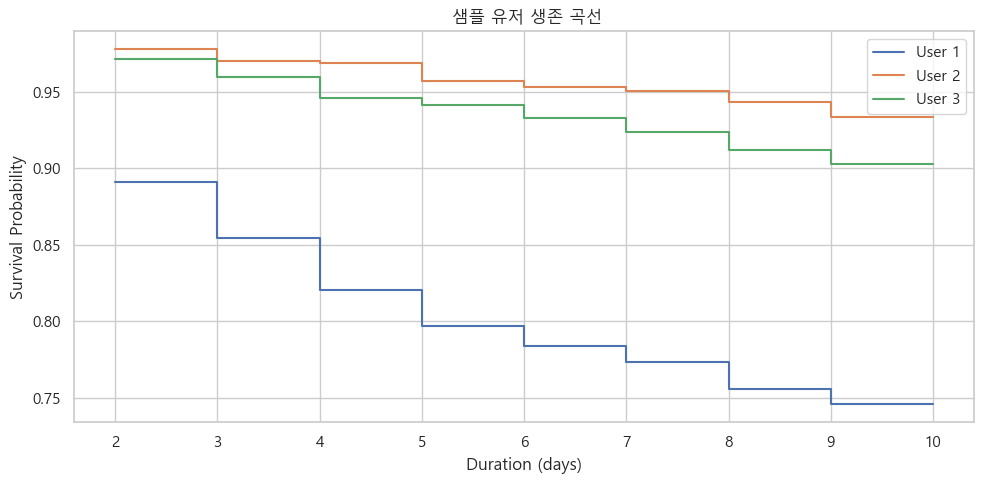

In [18]:
plt.figure(figsize=(10, 5))
# 생존 곡선 예시 (3명)
for i in range(3):
    surv_fn = rsf.predict_survival_function(X_test.iloc[[i]])[0]
    times = surv_fn.x  # 시간축
    probs = surv_fn.y  # 생존확률
    plt.step(times, probs, where="post", label=f"User {i+1}")

plt.title(" 샘플 유저 생존 곡선")
plt.xlabel("Duration (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

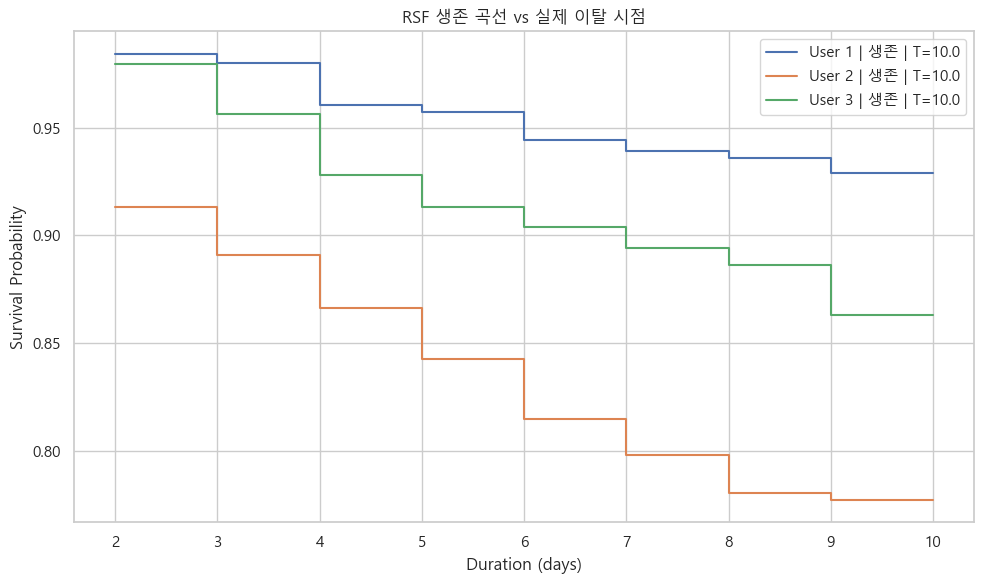

In [19]:
# X_test, y_test에서 일부 유저 선택 (event=1 또는 전체 중)
n = 3
sample_idx = np.random.choice(len(X_test), size=n, replace=False)

plt.figure(figsize=(10, 6))

for i, idx in enumerate(sample_idx):
    surv_fn = rsf.predict_survival_function(X_test.iloc[[idx]])[0]
    times = surv_fn.x
    probs = surv_fn.y

    # 실제 이탈 여부 및 기간
    actual_event = y_test["event"][idx]
    actual_duration = y_test["duration"][idx]

    label = f"User {i+1} | {'이탈' if actual_event else '생존'} | T={actual_duration}"
    plt.step(times, probs, where="post", label=label)

    # 실제 이탈 시점 표시
    if actual_event:
        plt.axvline(actual_duration, color=f'C{i}', linestyle='--', alpha=0.6)

plt.title("RSF 생존 곡선 vs 실제 이탈 시점")
plt.xlabel("Duration (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
from sksurv.metrics import integrated_brier_score
from sksurv.metrics import integrated_brier_score
#Brier Score	시간별 예측 생존확률의 평균 제곱 오차
# 1. 시간축 설정 (중도절단 범위 내에서만)
time_points = np.linspace(2, y_test["duration"].max() - 0.1, 100)

# 2. 생존 함수 예측 (확률값 추출)
surv_funcs = rsf.predict_survival_function(X_test)

# 3. 생존 확률을 2D array로 변환: (n_samples x n_timepoints)
pred_probs = np.asarray([[fn(t) for t in time_points] for fn in surv_funcs])

# 4. Integrated Brier Score 계산
ibs = integrated_brier_score(y_train, y_test, pred_probs, time_points)
print(f"📉 Integrated Brier Score (IBS): {ibs:.4f}")


📉 Integrated Brier Score (IBS): 0.0591


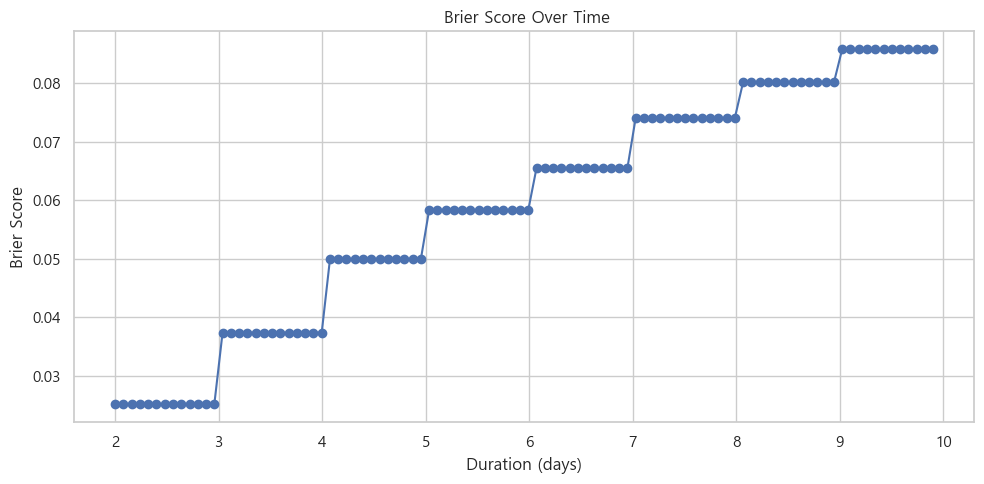

In [28]:
# 13. Brier Score over time 시각화
from sksurv.metrics import brier_score

# 시간 포인트 설정
time_points = np.linspace(2, y_test["duration"].max() - 0.1, 100)

# 생존 확률 예측
surv_funcs = rsf.predict_survival_function(X_test)
pred_probs = np.asarray([[fn(t) for t in time_points] for fn in surv_funcs])

# Brier Score 계산
_, bs_scores = brier_score(y_train, y_test, pred_probs, time_points)

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(time_points, bs_scores, marker="o")
plt.title(" Brier Score Over Time")
plt.xlabel("Duration (days)")
plt.ylabel("Brier Score")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import numpy as np
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
df = pd.read_csv("고정스냅샷(10월17일).csv", low_memory=False)

# 2. Unnamed index 제거
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# 3. 6차 전직 이상 필터링
df = df[df["character_class_level"] >= 6].copy()

# 4. 수치형 컬럼 변환
num_cols = ["character_level", "character_exp", "popularity", "authentic_sum", 
            "dojang_best_floor", "duration"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 5. 결측치 제거
df = df.dropna(subset=num_cols + ["event"])

# 6. duration > 0 필터링
df = df[df["duration"] > 0]

# 7. 캐릭터 생성일 처리
df["character_date_create"] = pd.to_datetime(df["character_date_create"], errors="coerce")
df = df.dropna(subset=["character_date_create"])

# 7. 캐릭터 생성일 처리 (시간대 제거 포함)
df["character_date_create"] = pd.to_datetime(df["character_date_create"], errors="coerce").dt.tz_localize(None)
df = df.dropna(subset=["character_date_create"])

# 8. 기준일 대비 캐릭터 나이 계산
reference_date = pd.to_datetime("2024-10-17")
df["create_age_days"] = (reference_date - df["character_date_create"]).dt.days

# 9. 길드 유무 파생 변수
df["guild_flag"] = (df["character_guild_name"] != "미가입").astype(int)

# 10. 범주형 변수 원-핫 인코딩
df_encoded = pd.get_dummies(df[["character_class", "world_name"]], drop_first=True)

# 11. 피처 정의 (생성일 포함)
features = [
    "character_level", "character_exp", "popularity", "authentic_sum",
    "liberation_quest_clear_flag", "dojang_best_floor", "guild_flag",
    "create_age_days"
]

# 12. X, y 구성
X = pd.concat([df[features], df_encoded], axis=1)
y = Surv.from_dataframe("event", "duration", df)

# 13. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 14. RSF 모델 학습
rsf = RandomSurvivalForest(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
rsf.fit(X_train, y_train)

# 15. Concordance Index 출력
cindex = concordance_index_censored(
    y_test["event"], y_test["duration"], rsf.predict(X_test)
)[0]
print(f"✅ Concordance Index (C-index): {cindex:.4f}")


✅ Concordance Index (C-index): 0.6980


In [2]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

# Permutation Importance
result = permutation_importance(
    rsf, X_test, y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

# 결과 정리
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importance_df)


               feature  importance_mean  importance_std
0      character_level         0.074733        0.002207
3        authentic_sum         0.041898        0.001773
6           guild_flag         0.030431        0.001273
7      create_age_days         0.027521        0.001273
5    dojang_best_floor         0.012014        0.001075
..                 ...              ...             ...
62      world_name_제니스        -0.000180        0.000083
45  character_class_캡틴        -0.000216        0.000023
55       world_name_베라        -0.000307        0.000203
56     world_name_스카니아        -0.000632        0.000284
54       world_name_루나        -0.000729        0.000149

[64 rows x 3 columns]


<Axes: >

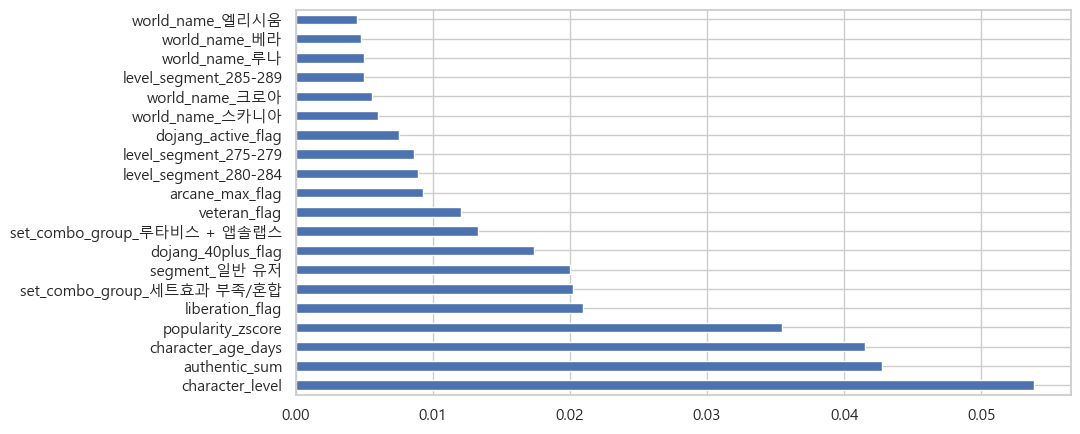

In [163]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rsf, X, y,
    n_repeats=5,
    random_state=42,
    n_jobs=1  # ← 병렬처리 안 쓰고 안정적으로 돌림
)

importances = pd.Series(result.importances_mean, index=X.columns)
importances.sort_values(ascending=False).head(20).plot(kind='barh')


In [8]:
#  라이브러리
import pandas as pd
import numpy as np
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

#  데이터 불러오기 (전체 사용)
df = pd.read_csv("머신러닝용고정스냅샷.csv", low_memory=False)
df["popularity_zscore"] = df["popularity_zscore"].fillna(0)
#길드 유무 파생 변수
df["guild_flag"] = (df["character_guild_name"] != "미가입").astype(int)
#  수치형 안정화
numeric_cols = ["character_level", "authentic_sum", "popularity_zscore", "character_age_days"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

#  범주형 피처 원핫 인코딩
categorical_cols = ["segment", "level_segment", "set_combo_group", "character_class", "world_name"]
df_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)


#  최종 피처셋
X = pd.concat([
    df[[
        "character_level","authentic_sum", "popularity_zscore", "character_age_days",
        "new_user_flag", "veteran_flag", "liberation_flag", "arcane_max_flag",
        "dojang_active_flag", "dojang_40plus_flag","guild_flag"
    ]],
    df_encoded
], axis=1)

#  타겟 생성
y = Surv.from_dataframe("event", "duration", df)

#  학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  RSF 모델 학습
rsf = RandomSurvivalForest(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=10,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
rsf.fit(X_train, y_train)

#  평가 - C-index
cindex = concordance_index_censored(y_test["event"], y_test["duration"], rsf.predict(X_test))[0]
print(f" Concordance Index (C-index): {cindex:.4f}")

#  모델과 데이터 저장 (커널 재시작 대비)
import pickle

joblib.dump(rsf, "rsf_model.pkl")
X_train.to_pickle("X_train.pkl")
X_test.to_pickle("X_test.pkl")
with open("y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)
with open("y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)


 Concordance Index (C-index): 0.7110


In [210]:
from sklearn.metrics import classification_report
import numpy as np

# 예: 6주차 기준 생존확률 추출
surv_funcs = rsf.predict_survival_function(X_test)
s6 = np.array([fn(6) for fn in surv_funcs])

# 6주차 생존확률 기준 0.85 이하 → 이탈 예측
y_pred = (s6 < 0.85).astype(int)
y_true = y_test["event"].astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))



              precision    recall  f1-score   support

           0       0.91      0.94      0.92     37587
           1       0.26      0.21      0.23      4176

    accuracy                           0.86     41763
   macro avg       0.59      0.57      0.58     41763
weighted avg       0.85      0.86      0.86     41763



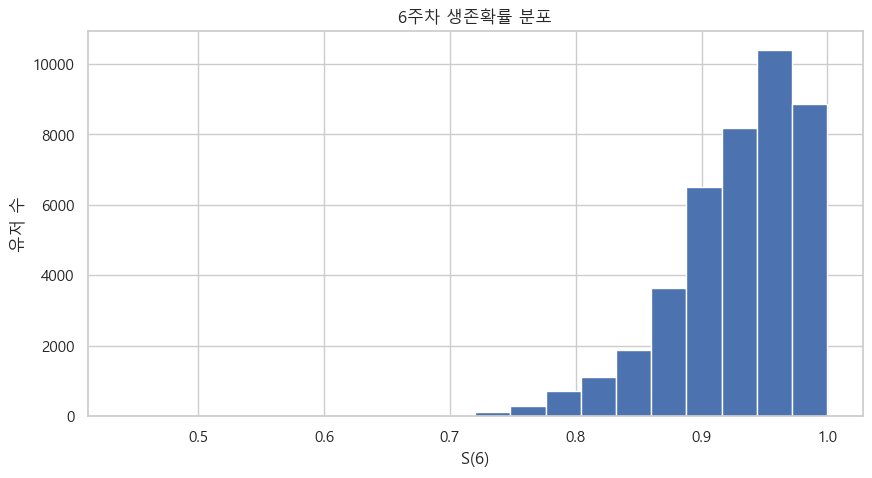

In [170]:
import matplotlib.pyplot as plt
plt.hist(s6, bins=20)
plt.title("6주차 생존확률 분포")
plt.xlabel("S(6)")
plt.ylabel("유저 수")
plt.show()


In [175]:
# ✅ 전체 분류 모델 설계 및 저장 코드 (RandomForestClassifier 기반)

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# 📌 1. 데이터 불러오기
df = pd.read_csv("머신러닝용고정스냅샷.csv", low_memory=False)
df["popularity_zscore"] = df["popularity_zscore"].fillna(0)

# 📌 2. 수치형 안정화
numeric_cols = ["character_level", "authentic_sum", "popularity_zscore", "character_age_days"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 📌 3. 범주형 인코딩
categorical_cols = ["segment", "level_segment", "set_combo_group", "character_class", "world_name"]
df_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)

# 📌 4. 피처셋 구성 (duration, event 제거)
X = pd.concat([
    df[[
        "character_level", "authentic_sum", "popularity_zscore", "character_age_days",
        "new_user_flag", "veteran_flag", "liberation_flag", "arcane_max_flag",
        "dojang_active_flag", "dojang_40plus_flag"
    ]],
    df_encoded
], axis=1)

y = df["event"]  # 타겟: 이탈 여부

# 📌 5. 학습/검증 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 📌 6. 모델 학습
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
clf.fit(X_train, y_train)

# 📌 7. 평가
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

classification_report_text = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

# 📌 8. 저장
joblib.dump(clf, "rf_classifier_model.pkl")
X_train.to_pickle("X_train_cls.pkl")
X_test.to_pickle("X_test_cls.pkl")
y_train.to_pickle("y_train_cls.pkl")
y_test.to_pickle("y_test_cls.pkl")

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))



              precision    recall  f1-score   support

           0       0.90      0.82      0.86     37587
           1       0.10      0.18      0.13      4176

    accuracy                           0.76     41763
   macro avg       0.50      0.50      0.49     41763
weighted avg       0.82      0.76      0.79     41763



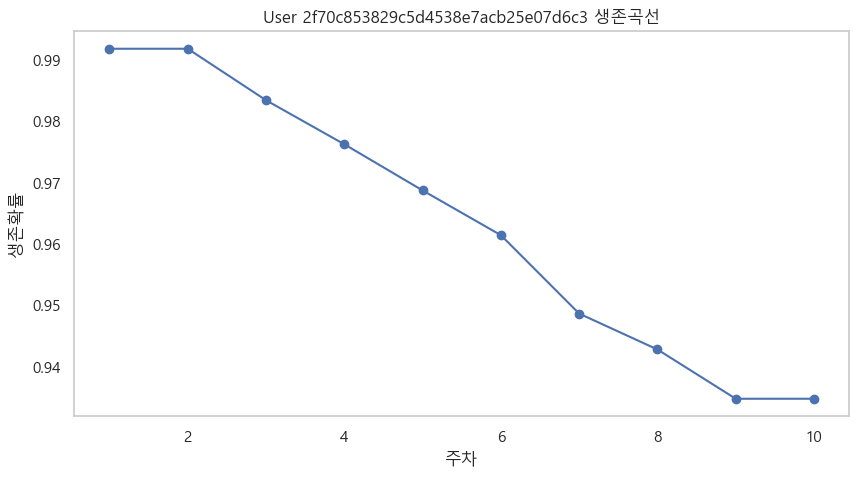

In [176]:
import matplotlib.pyplot as plt

# ocid로 유저 인덱스 찾기
target_ocid = "2f70c853829c5d4538e7acb25e07d6c3"
target_index = df[df["ocid"] == target_ocid].index[0]

# 해당 유저 row → X 포맷으로 추출
X_target = X.loc[[target_index]]

# 생존함수 얻기
surv_fn = rsf.predict_survival_function(X_target)[0]

# 생존곡선 그리기 (1~10주차 예시)
weeks = list(range(1, 11))
probs = [surv_fn(w) for w in weeks]

plt.plot(weeks, probs, marker="o")
plt.title(f"User {target_ocid} 생존곡선")
plt.xlabel("주차")
plt.ylabel("생존확률")
plt.grid()
plt.show()


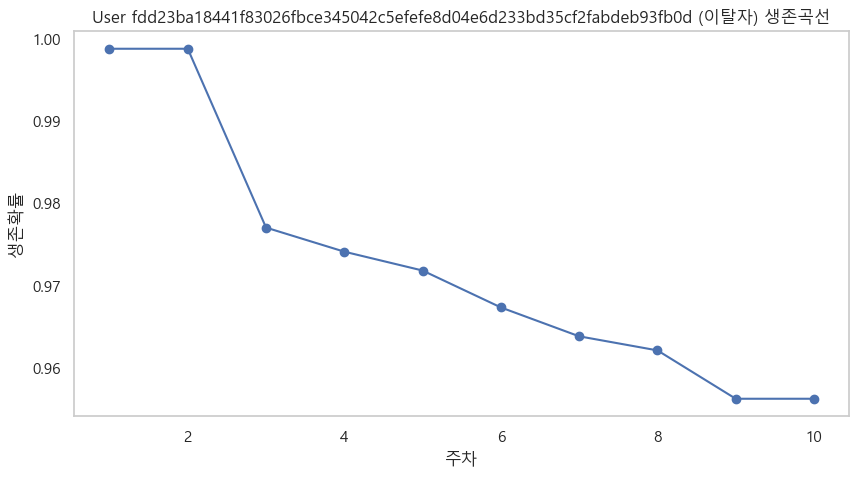

In [177]:
# event == 1 (이탈자)인 유저만 필터
df_event_1 = df[df["event"] == 1]

# 아무 유저 하나 ocid 확인
sample_ocid = df_event_1.iloc[0]["ocid"]

# 해당 ocid에 대해 생존곡선 그리기
idx = df[df["ocid"] == sample_ocid].index[0]
X_target = X.loc[[idx]]
surv_fn = rsf.predict_survival_function(X_target)[0]

weeks = list(range(1, 11))
probs = [surv_fn(w) for w in weeks]

plt.plot(weeks, probs, marker="o")
plt.title(f"User {sample_ocid} (이탈자) 생존곡선")
plt.xlabel("주차")
plt.ylabel("생존확률")
plt.grid()
plt.show()


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sksurv.ensemble import RandomSurvivalForest

# ✅ 모델 및 데이터 로딩
rsf = joblib.load("rsf_model.pkl")
X = pd.read_pickle("X_train.pkl")  # 병합된 전체 데이터프레임
df = pd.read_csv("머신러닝용고정스냅샷.csv", low_memory=False)

# ✅ 생존함수 계산
surv_fns = rsf.predict_survival_function(X)

# ✅ 주차별 생존확률을 행렬로 추출 (1~10주차)
weeks = np.arange(1, 11)
surv_probs_matrix = np.array([[fn(w) for w in weeks] for fn in surv_fns])

# ✅ event 컬럼 병합
X["event"] = df.loc[X.index, "event"].values

# ✅ 평균 생존확률 계산
mean_surv_0 = surv_probs_matrix[X["event"] == 0].mean(axis=0)
mean_surv_1 = surv_probs_matrix[X["event"] == 1].mean(axis=0)

# ✅ 시각화
plt.figure(figsize=(8, 5))
plt.plot(weeks, mean_surv_0, label="비이탈자 평균", marker="o")
plt.plot(weeks, mean_surv_1, label="이탈자 평균", marker="o")
plt.title("이탈자 vs 비이탈자 평균 생존곡선")
plt.xlabel("주차")
plt.ylabel("생존확률")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'sklearn.ensemble._gb_losses'

In [188]:
import pandas as pd

# 1. 데이터 불러오기
df2 = pd.read_csv("time_varying_with_all_changes.csv", low_memory=False)
# 2. 날짜형 변환 및 기준일 설정
df2["start_date"] = pd.to_datetime(df2["start_date"])
df2["stop_date"] = pd.to_datetime(df2["stop_date"])
start_point = df2["start_date"].min()
df2["start"] = (df2["start_date"] - start_point).dt.days
df2["stop"] = (df2["stop_date"] - start_point).dt.days

# 3. 주차 생성 (정상 주차 흐름 파악용)
df2["week"] = ((df2["start_date"] - start_point).dt.days // 7) + 1
df2 = df2[df2["week"] <= 9]
# ocid 기준으로 유저 5명 샘플링
sampled_ocids = df2["ocid"].dropna().unique()[:5]  # 또는 .sample(n=5, random_state=42)

# 샘플링한 유저 데이터만 추출
df_sampled = df2[df2["ocid"].isin(sampled_ocids)].sort_values(["ocid", "week"])

# 저장해서 ChatGPT에 올리기
df_sampled.to_csv("샘플_유저_time_varying.csv", index=False)


In [ ]:
# 날짜 처리
df2["character_date_create"] = pd.to_datetime(df2["character_date_create"], errors="coerce")
df2["character_date_create"] = df2["character_date_create"].dt.tz_localize(None)
reference_date = pd.to_datetime("2024-10-17")
df2["character_age_days"] = (reference_date - df2["character_date_create"]).dt.days

In [9]:
import pandas as pd
import numpy as np
from datetime import datetime
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 샘플 데이터 로드
df2 = pd.read_csv("time_varying_with_all_changes.csv", low_memory=False)
# 2. 날짜형 변환 및 기준일 설정
df2["start_date"] = pd.to_datetime(df2["start_date"])
df2["stop_date"] = pd.to_datetime(df2["stop_date"])
start_point = df2["start_date"].min()
df2["start"] = (df2["start_date"] - start_point).dt.days
df2["stop"] = (df2["stop_date"] - start_point).dt.days

# 3. 주차 생성 (정상 주차 흐름 파악용)
df2["week"] = ((df2["start_date"] - start_point).dt.days // 7) + 1
df2 = df2[df2["week"] <= 9]

# 날짜 처리
df2["character_date_create"] = pd.to_datetime(df2["character_date_create"], errors="coerce")
df2["character_date_create"] = df2["character_date_create"].dt.tz_localize(None)
reference_date = pd.to_datetime("2024-10-17")
df2["character_age_days"] = (reference_date - df2["character_date_create"]).dt.days
# 유저별 주차 정렬
df2 = df2.sort_values(by=["ocid", "week"])

# 🔄 변화량 직접 계산
df2["guild_flag_change"] = df2.groupby("ocid")["guild_flag"].diff().fillna(0)
df2["liberation_flag_change"] = df2.groupby("ocid")["liberation_flag"].diff().fillna(0)

#  시계열 피처 최종 확정
time_cols = [
    "guild_flag_change", 
    "liberation_flag_change", 
    "authentic_sum_change", 
    "popularity_change"
]

#  정적 피처 최종 확정
static_cols = [
    "character_class", 
    "world_name", 
    "character_age_days"
]

# 정적 피처 인코딩 (직업, 서버 → 원핫)
df_static = df2.drop_duplicates("ocid")[["ocid"] + static_cols].copy()
df_static = pd.get_dummies(df_static, columns=["character_class", "world_name"], drop_first=True)

# 타겟 구성
df_target = df2.drop_duplicates("ocid")[["ocid", "stop", "event"]].copy()
df_meta = pd.merge(df_static, df_target, on="ocid")

# 시계열 및 정적 피처, 타겟 분리
X_time, X_static, y_duration, y_event = [], [], [], []

for ocid, group in df2.groupby("ocid"):
    group = group.sort_values("week")

    sequence = group[time_cols].values
    sequence_padded = pad_sequences([sequence], maxlen=10, padding="post", dtype="float32")[0]

    if ocid not in df_meta["ocid"].values:
        continue

    static_values = df_meta[df_meta["ocid"] == ocid].drop(columns=["ocid", "stop", "event"]).values[0]
    duration = df_meta[df_meta["ocid"] == ocid]["stop"].values[0]
    event = df_meta[df_meta["ocid"] == ocid]["event"].values[0]

    X_time.append(sequence_padded)
    X_static.append(static_values)
    y_duration.append(duration)
    y_event.append(event)

# numpy 변환
X_time = np.array(X_time)
X_static = np.array(X_static)
y_duration = np.array(y_duration)
y_event = np.array(y_event)

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Masking, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam

# 시계열 입력 (10주 × 4피처)
input_seq = Input(shape=(10, 4), name="time_input")
x = Masking(mask_value=0.)(input_seq)
x = LSTM(64, return_sequences=False)(x)

# 정적 입력 (직업/월드/경과일 등)
input_static = Input(shape=(X_static.shape[1],), name="static_input")
s = Dense(32, activation="relu")(input_static)

# 병합
merged = Concatenate()([x, s])
merged = Dense(32, activation="relu")(merged)
output = Dense(1, activation="sigmoid", name="surv_prob")(merged)  # 생존확률 (이탈 확률의 반대)

# 모델 정의
model = Model(inputs=[input_seq, input_static], outputs=output)

# 컴파일 (우선 binary_crossentropy로 단순 이탈 분류 목적)
model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=["accuracy"])


In [ ]:
model.fit(
    x=[X_time, X_static],
    y=1 - y_event,  # 생존 예측을 위해 event=0이 양성
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


In [ ]:
# 생존 확률 예측
y_pred_survprob = model.predict([X_time, X_static])

# 이탈 확률 = 1 - 생존확률
y_pred_churnprob = 1 - y_pred_survprob


In [3]:
import joblib
import pickle
import pandas as pd

# 모델 불러오기
rsf = joblib.load("rsf_model.pkl")

# 데이터 불러오기
X_train = pd.read_pickle("X_train.pkl")
X_test = pd.read_pickle("X_test.pkl")

with open("y_train.pkl", "rb") as f:
    y_train = pickle.load(f)
with open("y_test.pkl", "rb") as f:
    y_test = pickle.load(f)


In [3]:
from sksurv.metrics import concordance_index_censored

# RSF 예측 위험도 (낮을수록 생존 확률 높음)
risk_scores = rsf.predict(X_test)

# C-index 계산
cindex = concordance_index_censored(
    y_test["event"], y_test["duration"], risk_scores
)[0]

print(f"📊 Concordance Index (C-index): {cindex:.4f}")


📊 Concordance Index (C-index): 0.7110


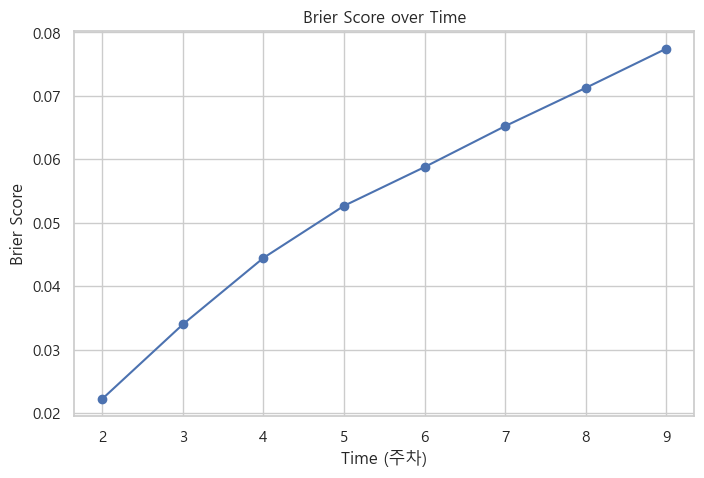

In [4]:
from sksurv.metrics import brier_score
import numpy as np
import matplotlib.pyplot as plt

# 평가 시간 시점 (y_test duration 범위 내에서 설정)
times = np.arange(2, 10)

# 생존 함수 예측
surv_funcs = rsf.predict_survival_function(X_test)
surv_preds_array = np.asarray([[fn(t) for t in times] for fn in surv_funcs])

# Brier Score 계산
score_times, brier_scores = brier_score(y_train, y_test, surv_preds_array, times)

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(score_times, brier_scores, marker='o')
plt.title("Brier Score over Time")
plt.xlabel("Time (주차)")
plt.ylabel("Brier Score")
plt.grid(True)
plt.show()


In [4]:
# 테스트 데이터 내에서 가능한 시간 범위 자동 계산
min_time = int(np.floor(np.min([y[1] for y in y_test])))
max_time = int(np.floor(np.max([y[1] for y in y_test])))

# 시간 범위 설정: 관측된 duration 내에서만 평가
times = np.arange(min_time, max_time)

# 생존 함수 예측
surv_funcs = rsf.predict_survival_function(X_test)
preds_array = np.asarray([[fn(t) for t in times] for fn in surv_funcs])

# IBS 계산
from sksurv.metrics import integrated_brier_score
ibs = integrated_brier_score(y_train, y_test, preds_array, times)
print(f"📉 Integrated Brier Score (IBS): {ibs:.4f}")


📉 Integrated Brier Score (IBS): 0.0579


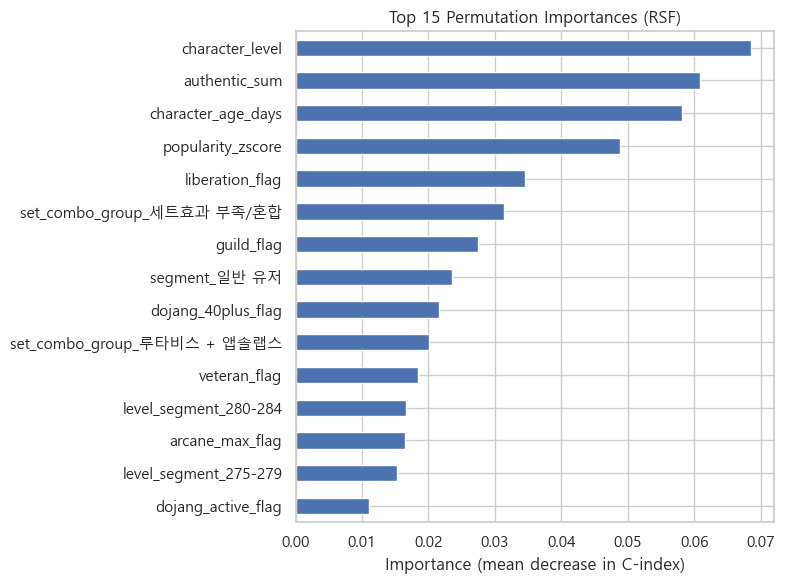

In [5]:
from sklearn.inspection import permutation_importance

# Permutation Importance 계산
result = permutation_importance(
    rsf, X_test, y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

# 중요도 추출 + 시각화
importances = pd.Series(result.importances_mean, index=X_test.columns)
importances.sort_values(ascending=True).tail(15).plot(kind='barh', figsize=(8,6))
plt.title("Top 15 Permutation Importances (RSF)")
plt.xlabel("Importance (mean decrease in C-index)")
plt.tight_layout()
plt.show()


In [9]:
# 중요도 추출 + 시각화
importances = pd.Series(result.importances_mean, index=X_test.columns)
importances.sort_values(ascending=True).tail(15).plot(kind='barh', figsize=(8,6))
plt.title("Top 15 Permutation Importances (RSF)")
plt.xlabel("Importance (mean decrease in C-index)")
plt.tight_layout()
plt.show()

NameError: name 'result' is not defined

In [9]:
top5 = importances.sort_values(ascending=False).head(5)
top5_pct = (top5 / top5.sum() * 100).round(1)
print(top5_pct)


set_combo_group_세트효과 부족/혼합    29.0
character_level               28.1
authentic_sum                 23.4
liberation_flag                9.8
character_age_days             9.7
dtype: float64


In [15]:
import joblib
import pickle
import pandas as pd
from sksurv.functions import StepFunction

# 모델 및 데이터 불러오기
rsf = joblib.load("rsf_model.pkl")
X_test = pd.read_pickle("X_test.pkl")

# 생존함수 예측
surv_funcs = rsf.predict_survival_function(X_test)

# 9주차 생존확률 계산
target_week = 9
survival_probs_at_week = []
for fn in surv_funcs:
    idx = (fn.x >= target_week).argmax() if any(fn.x >= target_week) else -1
    survival_probs_at_week.append(fn.y[idx] if idx != -1 else fn.y[-1])


# 결과 결합
df_result = X_test.copy()
df_result["survival_prob_9w"] = survival_probs_at_week
df_result["risk_score"] = 1 - df_result["survival_prob_9w"]


# 상위 5개 미리보기
df_result.head()


,character_level,authentic_sum,popularity_zscore,character_age_days,new_user_flag,veteran_flag,liberation_flag,arcane_max_flag,dojang_active_flag,dojang_40plus_flag,...,world_name_스카니아,world_name_아케인,world_name_엘리시움,world_name_오로라,world_name_유니온,world_name_이노시스,world_name_제니스,world_name_크로아,survival_prob_9w,risk_score
76912,281,41,-0.284631,288,0,0,0,1,1,0,...,True,False,False,False,False,False,False,False,0.927645,0.072355
117772,277,41,-0.032134,2642,0,1,1,1,1,1,...,False,False,True,False,False,False,False,False,0.903249,0.096751
107888,278,32,-0.047745,2308,0,1,0,1,1,1,...,False,False,False,False,False,False,False,False,0.902440,0.097560
189888,271,17,-0.135739,395,0,0,0,1,1,0,...,False,False,False,False,False,False,False,False,0.820083,0.179917
7143,289,55,-0.193096,1653,0,0,1,1,1,1,...,False,False,True,False,False,False,False,False,0.988102,0.011898


In [16]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41763 entries, 76912 to 14512
Data columns (total 78 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   character_level                41763 non-null  int64  
 1   authentic_sum                  41763 non-null  int64  
 2   popularity_zscore              41763 non-null  float64
 3   character_age_days             41763 non-null  int64  
 4   new_user_flag                  41763 non-null  int64  
 5   veteran_flag                   41763 non-null  int64  
 6   liberation_flag                41763 non-null  int64  
 7   arcane_max_flag                41763 non-null  int64  
 8   dojang_active_flag             41763 non-null  int64  
 9   dojang_40plus_flag             41763 non-null  int64  
 10  segment_일반 유저                  41763 non-null  bool   
 11  level_segment_275-279          41763 non-null  bool   
 12  level_segment_280-284          41763 non-null  

In [14]:
# 1. 라이브러리 불러오기
import pandas as pd
import numpy as np
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.functions import StepFunction
import joblib

# 2. 데이터 불러오기
df = pd.read_csv("머신러닝용고정스냅샷.csv", low_memory=False)
df["popularity_zscore"] = df["popularity_zscore"].fillna(0)
df["guild_flag"] = (df["character_guild_name"] != "미가입").astype(int)
# 3. 수치형 안정화
numeric_cols = ["character_level", "authentic_sum", "popularity_zscore", "character_age_days"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 4. 범주형 피처 원핫 인코딩
categorical_cols = ["segment", "level_segment", "set_combo_group", "character_class", "world_name"]
df_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)

# 5. 최종 피처셋
X = pd.concat([
    df[[
        "character_level", "authentic_sum", "popularity_zscore", "character_age_days",
        "new_user_flag", "veteran_flag", "liberation_flag", "arcane_max_flag",
        "dojang_active_flag", "dojang_40plus_flag","guild_flag"
    ]],
    df_encoded
], axis=1)

# 6. 타겟 생성
y = Surv.from_dataframe("event", "duration", df)

# 7. RSF 모델 학습 (이미 학습된 모델 사용 가능)
rsf = RandomSurvivalForest(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=10,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
rsf.fit(X, y)

# 8. 전체 유저 생존함수 예측
surv_funcs = rsf.predict_survival_function(X)
# 9. 모델과 입력 데이터 저장
joblib.dump(rsf, "rsf_model.pkl")
X.to_pickle("X_for_streamlit.pkl")

print("✅ 저장 완료: rsf_model.pkl, X_for_streamlit.pkl")


✅ 저장 완료: rsf_model.pkl, X_for_streamlit.pkl


In [1]:
# 1. 라이브러리 불러오기
import pandas as pd
import numpy as np
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.functions import StepFunction
import joblib

# 2. 데이터 불러오기
df = pd.read_csv("머신러닝용고정스냅샷.csv", low_memory=False)
df["popularity_zscore"] = df["popularity_zscore"].fillna(0)
df["guild_flag"] = (df["character_guild_name"] != "미가입").astype(int)
# 3. 수치형 안정화
numeric_cols = ["character_level", "authentic_sum", "popularity_zscore", "character_age_days"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 4. 범주형 피처 원핫 인코딩
categorical_cols = ["segment", "level_segment", "set_combo_group", "character_class", "world_name"]
df_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)

# 5. 최종 피처셋
X = pd.concat([
    df[[
        "character_level", "authentic_sum", "popularity_zscore", "character_age_days",
        "new_user_flag", "veteran_flag", "liberation_flag", "arcane_max_flag",
        "dojang_active_flag", "dojang_40plus_flag","guild_flag"
    ]],
    df_encoded
], axis=1)

# 6. 타겟 생성
y = Surv.from_dataframe("event", "duration", df)

# 7. RSF 모델 학습 (이미 학습된 모델 사용 가능)
rsf = RandomSurvivalForest(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=10,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
rsf.fit(X, y)

# 8. 전체 유저 생존함수 예측
surv_funcs = rsf.predict_survival_function(X)

# 9. 9주차 생존확률 계산
target_week = 9
survival_probs_9w = []
for fn in surv_funcs:
    idx = (fn.x >= target_week).argmax() if any(fn.x >= target_week) else -1
    survival_probs_9w.append(fn.y[idx] if idx != -1 else fn.y[-1])

# 10. 위험 점수 계산
risk_scores = [1 - prob for prob in survival_probs_9w]

# 11. 위험 등급 라벨링
def label_risk(score):
    if score >= 0.25:
        return "높음"
    elif score >= 0.15:
        return "중간"
    else:
        return "낮음"

risk_levels = [label_risk(score) for score in risk_scores]

# 12. 전체 컬럼 포함 + 결과 결합
df_result = df.copy()
df_result["survival_prob_9w"] = survival_probs_9w
df_result["risk_score"] = risk_scores
df_result["risk_level"] = risk_levels

# 13. 저장
df_result.to_csv("streamlit_full_user_prediction.csv", index=False)
print("✅ 전체 유저 예측 결과 저장 완료 → streamlit_full_user_prediction.csv")


✅ 전체 유저 예측 결과 저장 완료 → streamlit_full_user_prediction.csv


In [ ]:
streamlit_full_user_prediction.csv

In [2]:
df = pd.read_csv("streamlit_full_user_prediction.csv", low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208812 entries, 0 to 208811
Data columns (total 65 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ocid                         208812 non-null  object 
 1   exp_1010                     208812 non-null  object 
 2   ranking                      208812 non-null  object 
 3   character_name               208812 non-null  object 
 4   world_name                   208812 non-null  object 
 5   character_gender             208812 non-null  object 
 6   character_class              208812 non-null  object 
 7   character_class_level        208812 non-null  int64  
 8   character_level              208812 non-null  int64  
 9   character_exp                208812 non-null  float64
 10  character_exp_rate           208812 non-null  object 
 11  character_guild_name         208812 non-null  object 
 12  character_date_create        208812 non-null  object 
 13 

In [4]:
df2 = pd.read_csv("final_character_data_cleaned.csv", low_memory=False)

In [5]:
level_dist = df.groupby("risk_level")["character_level"].describe()

In [6]:
level_dist

,count,mean,std,min,25%,50%,75%,max
risk_level,,,,,,,,
낮음,168542.0,279.750899,5.303671,270.0,276.0,280.0,284.0,298.0
높음,7798.0,272.487048,3.211381,270.0,270.0,271.0,274.0,290.0
중간,32472.0,273.278147,3.346109,270.0,271.0,272.0,275.0,290.0


In [7]:
from sksurv.functions import StepFunction
import pandas as pd
import joblib

def compute_threshold_time(fn, threshold=0.7):
    for t, s in zip(fn.x, fn.y):
        if s <= threshold:
            return t
    return max(fn.x)  # 끝까지 threshold 안 내려가면 최대값 반환

# 적용
median_times_75 = [compute_threshold_time(fn, threshold=0.75) for fn in surv_funcs]
df["threshold75_time"] = median_times_75


In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208797 entries, 0 to 208796
Data columns (total 62 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ocid                         208797 non-null  object 
 1   exp_1010                     208797 non-null  object 
 2   ranking                      208797 non-null  object 
 3   character_name               208797 non-null  object 
 4   world_name                   208797 non-null  object 
 5   character_gender             208797 non-null  object 
 6   character_class              208797 non-null  object 
 7   character_class_level        208797 non-null  int64  
 8   character_level              208797 non-null  int64  
 9   character_exp                208797 non-null  float64
 10  character_exp_rate           208797 non-null  object 
 11  character_guild_name         208797 non-null  object 
 12  character_date_create        208797 non-null  object 
 13 

In [9]:
# df: 기존 예측 결과가 담긴 마스터 테이블
# df2: 캐릭터 이미지가 있는 보조 테이블

df_merged = df.merge(df2[["ocid", "character_image"]], on="ocid", how="left")


In [10]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208818 entries, 0 to 208817
Data columns (total 67 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ocid                         208818 non-null  object 
 1   exp_1010                     208818 non-null  object 
 2   ranking                      208818 non-null  object 
 3   character_name               208818 non-null  object 
 4   world_name                   208818 non-null  object 
 5   character_gender             208818 non-null  object 
 6   character_class              208818 non-null  object 
 7   character_class_level        208818 non-null  int64  
 8   character_level              208818 non-null  int64  
 9   character_exp                208818 non-null  float64
 10  character_exp_rate           208818 non-null  object 
 11  character_guild_name         208818 non-null  object 
 12  character_date_create        208818 non-null  object 
 13 

In [11]:
# character_image가 NaN인 행 제거
df_cleaned = df_merged.dropna(subset=["character_image"]).reset_index(drop=True)


In [12]:
print(df_cleaned["character_image"].isna().sum())  # → 0이어야 정상
print(df_cleaned.shape)  # 몇 행 남았는지 확인


0
(208722, 67)


In [13]:
df_cleaned.to_csv("streamlit_user_data_with_image.csv", index=False)

In [14]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208722 entries, 0 to 208721
Data columns (total 67 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ocid                         208722 non-null  object 
 1   exp_1010                     208722 non-null  object 
 2   ranking                      208722 non-null  object 
 3   character_name               208722 non-null  object 
 4   world_name                   208722 non-null  object 
 5   character_gender             208722 non-null  object 
 6   character_class              208722 non-null  object 
 7   character_class_level        208722 non-null  int64  
 8   character_level              208722 non-null  int64  
 9   character_exp                208722 non-null  float64
 10  character_exp_rate           208722 non-null  object 
 11  character_guild_name         208722 non-null  object 
 12  character_date_create        208722 non-null  object 
 13 

In [41]:
df['level_segment']

0         285-289
1            290+
2         285-289
3         285-289
4            290+
           ...   
208807    285-289
208808    270-274
208809    270-274
208810       290+
208811    275-279
Name: level_segment, Length: 208812, dtype: object

In [15]:
joblib.dump(rsf, "rsf_model.pkl")


['rsf_model.pkl']

In [16]:
X["ocid"] = df["ocid"]  # ocid 붙여주기 (Streamlit info 매핑용)
X.to_pickle("X_for_streamlit.pkl")

In [ ]:
import pandas as pd
import joblib
from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_censored

# 데이터 로딩
X = pd.read_pickle("X_for_streamlit.pkl")
df = pd.read_csv("streamlit_full_user_prediction.csv", low_memory=False)
rsf = joblib.load("rsf_model.pkl")
# 💡 여기에 꼭 추가!
df["event"] = df["event"].astype(bool)
# 사용자 정의 scoring 함수
def rsf_cindex_score(model, X, y):
    preds = model.predict(X)
    return concordance_index_censored(y["event"], y["duration"], preds)[0]

# X, y 준비
X_input = X.drop(columns=["ocid"])
y_surv = df[["event", "duration"]].loc[X.index]  # index 맞춤!

# 중요도 계산
result = permutation_importance(
    rsf,
    X_input,
    y_surv,
    n_repeats=5,
    random_state=42,
    n_jobs=-1,
    scoring=rsf_cindex_score
)

# 저장
importance_df = pd.DataFrame({
    "feature": X_input.columns,
    "importance": result.importances_mean
}).sort_values(by="importance", ascending=False)

importance_df.to_csv("feature_importance.csv", index=False)
print("🎉 저장 완료: feature_importance.csv")




C:\Users\qhwhr\anaconda3\Lib\site-packages\sksurv\metrics.py:140: RuntimeWarning: overflow encountered in scalar add
  concordant += n_con


In [3]:
import pandas as pd
import joblib
from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_censored
rsf = joblib.load("rsf_model.pkl")

In [7]:
from sksurv.metrics import concordance_index_censored
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import time
import pandas as pd
import joblib
from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_censored

# ✅ 1. 학습에 쓴 피처셋 불러오기
X = pd.read_pickle("X_for_streamlit.pkl")
if "ocid" in X.columns:
    X = X.drop(columns=["ocid"])
# ✅ 2. 예측된 생존확률/이벤트/duration 포함된 결과 불러오기
df = pd.read_csv("streamlit_full_user_prediction.csv", low_memory=False)

# ✅ 3. 학습된 RSF 모델 불러오기
rsf = joblib.load("rsf_model.pkl")

# ✅ 4. event 컬럼 boolean 타입으로 캐스팅 (필수)
df["event"] = df["event"].astype(bool)

# ✅ 5. y 생성
y = df[["event", "duration"]].loc[X.index]

def rsf_cindex_score(model, X, y):
    preds = model.predict(X)
    return concordance_index_censored(y["event"], y["duration"], preds)[0]

# 원래 스코어
base_score = rsf_cindex_score(rsf, X, y)

# 변수 리스트
features = X.columns.tolist()
importances = []
n_repeats = 5

for i, feature in enumerate(features):
    print(f"🔁 진행 중: {i+1}/{len(features)} - 변수: {feature}")
    scores = []
    
    for _ in range(n_repeats):
        X_permuted = X.copy()
        X_permuted[feature] = shuffle(X_permuted[feature], random_state=42)
        score = rsf_cindex_score(rsf, X_permuted, y)
        scores.append(base_score - score)

    importances.append({
        "feature": feature,
        "importance_mean": np.mean(scores),
        "importance_std": np.std(scores)
    })

importance_df = pd.DataFrame(importances).sort_values(by="importance_mean", ascending=False)
importance_df.to_csv("rsf_feature_importance_cindex.csv", index=False)
print("✅ 저장 완료: rsf_feature_importance_cindex.csv")


C:\Users\qhwhr\anaconda3\Lib\site-packages\sksurv\metrics.py:140: RuntimeWarning: overflow encountered in scalar add
  concordant += n_con


🔁 진행 중: 1/77 - 변수: character_level


C:\Users\qhwhr\anaconda3\Lib\site-packages\sksurv\metrics.py:140: RuntimeWarning: overflow encountered in scalar add
  concordant += n_con
C:\Users\qhwhr\anaconda3\Lib\site-packages\sksurv\metrics.py:140: RuntimeWarning: overflow encountered in scalar add
  concordant += n_con
C:\Users\qhwhr\anaconda3\Lib\site-packages\sksurv\metrics.py:140: RuntimeWarning: overflow encountered in scalar add
  concordant += n_con
C:\Users\qhwhr\anaconda3\Lib\site-packages\sksurv\metrics.py:140: RuntimeWarning: overflow encountered in scalar add
  concordant += n_con
C:\Users\qhwhr\anaconda3\Lib\site-packages\sksurv\metrics.py:140: RuntimeWarning: overflow encountered in scalar add
  concordant += n_con


🔁 진행 중: 2/77 - 변수: authentic_sum


C:\Users\qhwhr\anaconda3\Lib\site-packages\sksurv\metrics.py:140: RuntimeWarning: overflow encountered in scalar add
  concordant += n_con
C:\Users\qhwhr\anaconda3\Lib\site-packages\sksurv\metrics.py:140: RuntimeWarning: overflow encountered in scalar add
  concordant += n_con
C:\Users\qhwhr\anaconda3\Lib\site-packages\sksurv\metrics.py:140: RuntimeWarning: overflow encountered in scalar add
  concordant += n_con


KeyboardInterrupt: 

In [9]:
from joblib import Parallel, delayed
from sksurv.metrics import concordance_index_censored
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import joblib

# ✅ 데이터 로딩
X = pd.read_pickle("X_for_streamlit.pkl")
if "ocid" in X.columns:
    X = X.drop(columns=["ocid"])

df = pd.read_csv("streamlit_full_user_prediction.csv", low_memory=False)
rsf = joblib.load("rsf_model.pkl")
df["event"] = df["event"].astype(bool)
y = df[["event", "duration"]].loc[X.index]

# ✅ C-index 기반 scoring 함수
def rsf_cindex_score(model, X, y):
    preds = model.predict(X)
    return concordance_index_censored(y["event"], y["duration"], preds)[0]

# ✅ base score (원래 성능)
base_score = rsf_cindex_score(rsf, X, y)

# ✅ permutation importance 계산 함수
def compute_importance(feature):
    scores = []
    for _ in range(5):  # 반복 횟수 설정
        X_permuted = X.copy()
        X_permuted[feature] = shuffle(X_permuted[feature], random_state=None)
        score = rsf_cindex_score(rsf, X_permuted, y)
        scores.append(base_score - score)
    return {
        "feature": feature,
        "importance_mean": np.mean(scores),
        "importance_std": np.std(scores)
    }

# ✅ 사용할 변수 리스트
selected_features = X.columns.tolist()  # 또는 [:30]처럼 제한 가능

# ✅ 병렬 처리 실행
results = Parallel(n_jobs=-1)(
    delayed(compute_importance)(feature) for feature in selected_features
)

# ✅ 결과 저장
importance_df = pd.DataFrame(results).sort_values(by="importance_mean", ascending=False)
importance_df.to_csv("rsf_feature_importance_cindex_parallel.csv", index=False)
print("✅ 병렬 처리로 저장 완료")


C:\Users\qhwhr\anaconda3\Lib\site-packages\sksurv\metrics.py:140: RuntimeWarning: overflow encountered in scalar add
  concordant += n_con


✅ 병렬 처리로 저장 완료


In [9]:
preds = rsf.predict(X)
print(np.min(preds), np.max(preds), np.mean(preds), np.std(preds))

0.0007643794958055867 6.245986273402791 0.5525310313959915 0.47689108793861185


In [2]:
from joblib import Parallel, delayed
from sksurv.metrics import concordance_index_censored
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import joblib
# ✅ 데이터 로딩
X = pd.read_pickle("X_for_streamlit.pkl")
if "ocid" in X.columns:
    X = X.drop(columns=["ocid"])


In [18]:
from sksurv.metrics import concordance_index_censored
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import time
import pandas as pd
import joblib
from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_censored
X = pd.read_pickle("X_for_streamlit.pkl")
if "ocid" in X.columns:
    X = X.drop(columns=["ocid"])

df = pd.read_csv("streamlit_full_user_prediction.csv", low_memory=False)
rsf = joblib.load("rsf_model.pkl")
df["event"] = df["event"].astype(bool)
y = df[["event", "duration"]].loc[X.index]

# ✅ C-index 기반 scoring 함수
def rsf_cindex_score(model, X, y):
    preds = model.predict(X)
    return concordance_index_censored(y["event"], y["duration"], preds)[0]
    # ✅ base score (원래 성능)
base_score = rsf_cindex_score(rsf, X, y)
print(f"Base C-index: {base_score:.4f}")

C:\Users\qhwhr\anaconda3\Lib\site-packages\sksurv\metrics.py:140: RuntimeWarning: overflow encountered in scalar add
  concordant += n_con


Base C-index: 0.8184


In [12]:
print((X.index == y.index).all())

NameError: name 'y' is not defined

In [19]:
print("인덱스 일치 여부:", X.index.equals(y.index))
print("샘플 5개 비교:\n", pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1).head())


인덱스 일치 여부: True
샘플 5개 비교:
    character_level  authentic_sum  popularity_zscore  character_age_days  \
0              289             61           0.077832                1761   
1              291             58           3.054288                2447   
2              289             66           0.040511                2113   
3              289             66           2.456531                3021   
4              290             66           0.296891                 943   

   new_user_flag  veteran_flag  liberation_flag  arcane_max_flag  \
0              0             0                1                1   
1              0             1                1                1   
2              0             1                0                1   
3              0             1                0                1   
4              0             0                1                1   

   dojang_active_flag  dojang_40plus_flag  ...  world_name_스카니아  \
0                   1                   

In [4]:
preds = rsf.predict(X)
print("min:", np.min(preds), "max:", np.max(preds), "std:", np.std(preds))


min: 0.0007643794958055867 max: 6.245986273402789 std: 0.4768910879386119


In [8]:
# ✅ 데이터 로딩
X = pd.read_pickle("X_for_streamlit.pkl")
if "ocid" in X.columns:
    X = X.drop(columns=["ocid"])

df = pd.read_csv("streamlit_full_user_prediction.csv", low_memory=False)
rsf = joblib.load("rsf_model.pkl")
df["event"] = df["event"].astype(bool)
y = df[["event", "duration"]].loc[X.index]

def rsf_cindex_score(model, X, y):
    preds = model.predict(X)
    preds = (preds - preds.min()) / (preds.max() - preds.min() + 1e-8)
    return concordance_index_censored(y["event"], y["duration"], preds)[0]
base_score = rsf_cindex_score(rsf, X, y)

# ✅ 중요도 계산 함수 (한 피처 테스트용)
def compute_importance(feature):
    scores = []
    for _ in range(5):
        X_permuted = X.copy()
        X_permuted[feature] = shuffle(X_permuted[feature], random_state=None)
        score = rsf_cindex_score(rsf, X_permuted, y)
        scores.append(base_score - score)
    return {
        "feature": feature,
        "importance_mean": np.mean(scores),
        "importance_std": np.std(scores)
    }

# ✅ 테스트: 첫 번째 피처만
test_feature = X.columns[0]
result = compute_importance(test_feature)

# ✅ 결과 출력
print("✅ 단일 피처 중요도 테스트 결과:")
print(result)


C:\Users\qhwhr\anaconda3\Lib\site-packages\sksurv\metrics.py:140: RuntimeWarning: overflow encountered in scalar add
  concordant += n_con
C:\Users\qhwhr\anaconda3\Lib\site-packages\sksurv\metrics.py:140: RuntimeWarning: overflow encountered in scalar add
  concordant += n_con
C:\Users\qhwhr\anaconda3\Lib\site-packages\sksurv\metrics.py:140: RuntimeWarning: overflow encountered in scalar add
  concordant += n_con
C:\Users\qhwhr\anaconda3\Lib\site-packages\sksurv\metrics.py:140: RuntimeWarning: overflow encountered in scalar add
  concordant += n_con
C:\Users\qhwhr\anaconda3\Lib\site-packages\sksurv\metrics.py:140: RuntimeWarning: overflow encountered in scalar add
  concordant += n_con
C:\Users\qhwhr\anaconda3\Lib\site-packages\sksurv\metrics.py:140: RuntimeWarning: overflow encountered in scalar add
  concordant += n_con


✅ 단일 피처 중요도 테스트 결과:
{'feature': 'character_level', 'importance_mean': 0.0, 'importance_std': 0.0}


In [9]:
from lifelines.utils import concordance_index
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import joblib

# ✅ 데이터 로딩
X = pd.read_pickle("X_for_streamlit.pkl")
if "ocid" in X.columns:
    X = X.drop(columns=["ocid"])

df = pd.read_csv("streamlit_full_user_prediction.csv", low_memory=False)
rsf = joblib.load("rsf_model.pkl")
df["event"] = df["event"].astype(bool)
y = df[["event", "duration"]].loc[X.index]

# ✅ lifelines 기반 안정적 C-index 함수
def rsf_cindex_score(model, X, y):
    preds = model.predict(X)
    preds = (preds - preds.min()) / (preds.max() - preds.min() + 1e-8)
    return concordance_index(y["duration"], -preds, event_observed=y["event"])

# ✅ base 성능
base_score = rsf_cindex_score(rsf, X, y)

# ✅ 중요도 계산 함수 (단일 피처용)
def compute_importance(feature):
    scores = []
    for _ in range(5):  # 반복 횟수 조절 가능
        X_permuted = X.copy()
        X_permuted[feature] = shuffle(X_permuted[feature], random_state=None)
        score = rsf_cindex_score(rsf, X_permuted, y)
        scores.append(base_score - score)
    return {
        "feature": feature,
        "importance_mean": np.mean(scores),
        "importance_std": np.std(scores)
    }

# ✅ 테스트할 피처 지정 (예: 첫 번째 피처)
test_feature = X.columns[0]
result = compute_importance(test_feature)

# ✅ 결과를 DataFrame으로 변환 후 저장
importance_df = pd.DataFrame([result])
importance_df.to_csv("test_single_feature_importance.csv", index=False)
print("✅ 단일 피처 중요도 저장 완료")
print(importance_df)


✅ 단일 피처 중요도 저장 완료
           feature  importance_mean  importance_std
0  character_level              0.0             0.0


In [13]:
# ✅ 테스트할 feature 하나 지정
test_feature = "authentic_sum"  # 또는 X.columns[1] 등

# ✅ 중요도 계산 실행
result = compute_importance(test_feature)

# ✅ 요약 결과 출력
print("✅ 단일 피처 중요도 테스트 결과:")
print(result)


    permuted score: 0.818385, Δ: 0.000000
    permuted score: 0.818385, Δ: 0.000000
    permuted score: 0.818385, Δ: 0.000000
    permuted score: 0.818385, Δ: 0.000000
    permuted score: 0.818385, Δ: 0.000000
✅ 단일 피처 중요도 테스트 결과:
{'feature': 'authentic_sum', 'importance_mean': 0.0, 'importance_std': 0.0}


In [19]:
# 1. 원본 예측
preds_original = rsf.predict(X)

# 2. 피처 셔플
X_permuted = X.copy()
X_permuted["popularity_zscore"] = np.random.permutation(X_permuted["popularity_zscore"].values)

# 3. 셔플 후 예측
preds_permuted = rsf.predict(X_permuted)

# 4. 차이 확인
diff = np.abs(preds_original - preds_permuted)
print("총 예측 차이 합계:", diff.sum())
print("예측값 차이 표준편차:", np.std(diff))
print("모든 값이 같은가:", np.allclose(preds_original, preds_permuted))


총 예측 차이 합계: 13663.167102277239
예측값 차이 표준편차: 0.0784281514252137
모든 값이 같은가: False


In [22]:
from lifelines.utils import concordance_index
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import joblib
from sklearn.utils import shuffle
from tqdm import tqdm  # ✅ 진행률 표시용

# ✅ 데이터 로딩
X = pd.read_pickle("X_for_streamlit.pkl")
if "ocid" in X.columns:
    X = X.drop(columns=["ocid"])

df = pd.read_csv("streamlit_full_user_prediction.csv", low_memory=False)
rsf = joblib.load("rsf_model.pkl")
df["event"] = df["event"].astype(bool)
y = df[["event", "duration"]].loc[X.index]

# ✅ 안정적인 C-index scoring 함수
def rsf_cindex_score(model, X, y):
    preds = model.predict(X)
    preds = (preds - preds.min()) / (preds.max() - preds.min() + 1e-8)
    return concordance_index(y["duration"], -preds, event_observed=y["event"])

# ✅ base C-index
base_score = rsf_cindex_score(rsf, X, y)
print(f"📌 Base C-index: {base_score:.10f}")

# ✅ 중요도 계산 함수 (개별 피처용)
def compute_importance(feature):
    scores = []
    for _ in range(5):
        X_permuted = X.copy()
        X_permuted[feature] = np.random.permutation(X_permuted[feature].values)
        score = rsf_cindex_score(rsf, X_permuted, y)
        delta = base_score - score
        scores.append(delta)
    return {
        "feature": feature,
        "importance_mean": np.mean(scores),
        "importance_std": np.std(scores)
    }

# ✅ tqdm 병렬 wrapper
def parallel_with_progress(func, iterable, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(func)(item) for item in tqdm(iterable, desc="🔄 Calculating importances")
    )
    return results

# ✅ 병렬 처리 실행
selected_features = X.columns.tolist()
results = parallel_with_progress(compute_importance, selected_features)

# ✅ 정렬 후 저장
importance_df = pd.DataFrame(results).sort_values(by="importance_mean", ascending=False)
importance_df.to_csv("rsf_feature_importance_lifelines.csv", index=False)

print("✅ 병렬 중요도 계산 및 CSV 저장 완료 → rsf_feature_importance_lifelines.csv")


📌 Base C-index: 0.8183849974


🔄 Calculating importances: 100%|██████████████████████████████████████████████████████| 77/77 [15:31<00:00, 12.09s/it]


✅ 병렬 중요도 계산 및 CSV 저장 완료 → rsf_feature_importance_lifelines.csv


In [9]:
import scipy.stats as stats
corr, pval = stats.pearsonr(X["character_level"], y["duration"])
print(f"📊 상관계수: {corr:.4f}, p-value: {pval:.4f}")


📊 상관계수: 0.1691, p-value: 0.0000


In [10]:
df = pd.read_csv("streamlit_user_data_with_image.csv", low_memory=False)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208722 entries, 0 to 208721
Data columns (total 67 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ocid                         208722 non-null  object 
 1   exp_1010                     208722 non-null  object 
 2   ranking                      208722 non-null  object 
 3   character_name               208722 non-null  object 
 4   world_name                   208722 non-null  object 
 5   character_gender             208722 non-null  object 
 6   character_class              208722 non-null  object 
 7   character_class_level        208722 non-null  int64  
 8   character_level              208722 non-null  int64  
 9   character_exp                208722 non-null  float64
 10  character_exp_rate           208722 non-null  object 
 11  character_guild_name         208722 non-null  object 
 12  character_date_create        208722 non-null  object 
 13 

In [15]:
X = pd.read_pickle("X_for_streamlit.pkl")
print("guild_flag" in X.columns)
# 또는
print(X.columns.tolist())


True
['character_level', 'authentic_sum', 'popularity_zscore', 'character_age_days', 'new_user_flag', 'veteran_flag', 'liberation_flag', 'arcane_max_flag', 'dojang_active_flag', 'dojang_40plus_flag', 'guild_flag', 'segment_일반 유저', 'level_segment_275-279', 'level_segment_280-284', 'level_segment_285-289', 'level_segment_290+', 'set_combo_group_루타비스 + 앱솔랩스', 'set_combo_group_세트효과 부족/혼합', 'set_combo_group_에테르넬 + 아케인셰이드', 'set_combo_group_에테르넬 + 앱솔랩스', 'set_combo_group_에테르넬 풀셋', 'character_class_나이트워커', 'character_class_다크나이트', 'character_class_데몬슬레이어', 'character_class_데몬어벤져', 'character_class_듀얼블레이더', 'character_class_라라', 'character_class_루미너스', 'character_class_메르세데스', 'character_class_메카닉', 'character_class_미하일', 'character_class_바이퍼', 'character_class_배틀메이지', 'character_class_보우마스터', 'character_class_블래스터', 'character_class_비숍', 'character_class_섀도어', 'character_class_소울마스터', 'character_class_스트라이커', 'character_class_신궁', 'character_class_아델', 'character_class_아란', 'character_class_아

In [16]:
print("✅ df에 guild_flag 있나?", "guild_flag" in df.columns)
print("✅ X에 guild_flag 있나?", "guild_flag" in X.columns)


✅ df에 guild_flag 있나? True
✅ X에 guild_flag 있나? True


In [17]:
X_with_ocid = X.copy()
X_with_ocid["ocid"] = df["ocid"]  # ✅ 식별자 포함
X_with_ocid.to_pickle("X_for_streamlit.pkl")  # 덮어쓰기


In [18]:
X = pd.read_pickle("X_for_streamlit.pkl")
print("X 컬럼:", X.columns.tolist())

X 컬럼: ['character_level', 'authentic_sum', 'popularity_zscore', 'character_age_days', 'new_user_flag', 'veteran_flag', 'liberation_flag', 'arcane_max_flag', 'dojang_active_flag', 'dojang_40plus_flag', 'guild_flag', 'segment_일반 유저', 'level_segment_275-279', 'level_segment_280-284', 'level_segment_285-289', 'level_segment_290+', 'set_combo_group_루타비스 + 앱솔랩스', 'set_combo_group_세트효과 부족/혼합', 'set_combo_group_에테르넬 + 아케인셰이드', 'set_combo_group_에테르넬 + 앱솔랩스', 'set_combo_group_에테르넬 풀셋', 'character_class_나이트워커', 'character_class_다크나이트', 'character_class_데몬슬레이어', 'character_class_데몬어벤져', 'character_class_듀얼블레이더', 'character_class_라라', 'character_class_루미너스', 'character_class_메르세데스', 'character_class_메카닉', 'character_class_미하일', 'character_class_바이퍼', 'character_class_배틀메이지', 'character_class_보우마스터', 'character_class_블래스터', 'character_class_비숍', 'character_class_섀도어', 'character_class_소울마스터', 'character_class_스트라이커', 'character_class_신궁', 'character_class_아델', 'character_class_아란', 'character_class_